# Speech Command Recognition 

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [0]:
useColab=False
if useColab:
    %tensorflow_version 1.x
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
    !pip install -r requirements.txt

In [0]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10688723287221354077
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1635314920309180250
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18038557316956187371
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3512802117997051992
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
%load_ext autoreload
%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

Using TensorFlow backend.


In [0]:
#Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task = '35word')

0it [00:00, ?it/s]

Google Speech commands dataset version 2 already exists. Skipping download.
Converting test set WAVs to numpy files
Converting training set WAVs to numpy files



0it [00:00, ?it/s]


Done preparing Google Speech commands dataset version 2


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [0]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
84849
36


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [0]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
#handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

#use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

155

In [0]:
audios, classes = valGen.__getitem__(5)
classes

array([ 5,  7, 19, 19,  1,  5, 12,  7, 18,  1, 11, 30, 24,  2, 17, 19,  1,
        1, 19,  9,  3, 10, 19,  2, 26, 33, 25, 17,  9, 32,  9,  4,  7, 30,
        9,  9,  4, 11, 35,  1,  7, 13,  4, 23,  3,  2,  7,  2, 11, 26, 27,
       19, 18,  6, 29, 17, 23, 23,  8, 20, 14, 28, 15,  3])

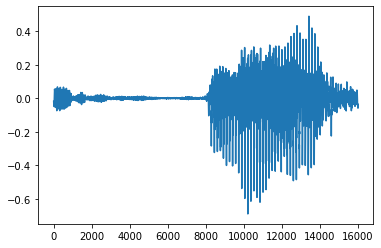

In [0]:
librosa.output.write_wav('file.wav', audios[4], sr, norm=False)
plt.plot(audios[4])

In [0]:
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d_2 (Normaliza (None, 80, 125, 1)        0         
Total params: 1,091,664
Trainable params: 0
Non-trainable params: 1,091,664
_________________________________________________________________


In [0]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(64, 80, 125, 1)

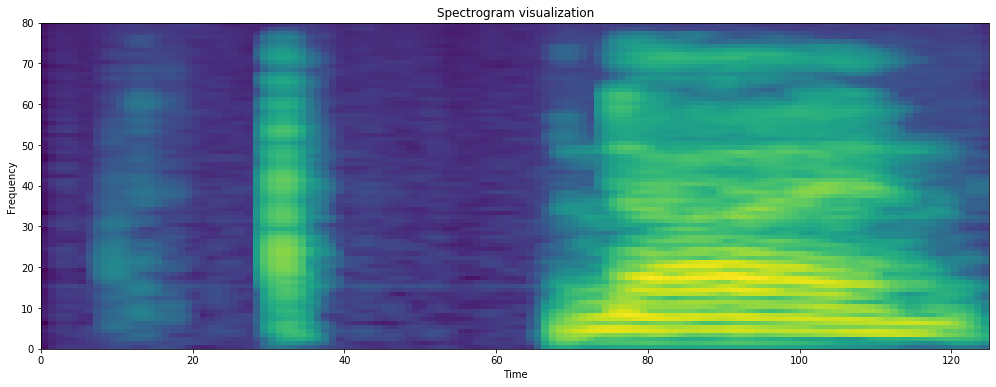

In [0]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[9,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [0]:
# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)

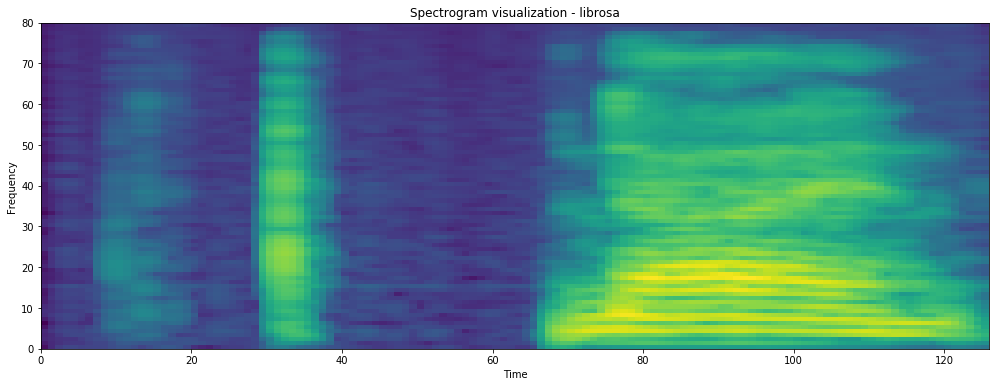

In [0]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [0]:
# plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [0]:
from keras.models import Model, load_model

from keras.layers import Input, Activation, Concatenate, Permute, Reshape, Flatten, Lambda, Dot, Softmax
from keras.layers import Add, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Dense, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers

from kapre.time_frequency import Melspectrogram, Spectrogram

In [0]:
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L

model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, None, 1)  1091664     reshape_1[0][0]                  
__________________________________________________________________________________________________
normalization2d_3 (Normalizatio (None, 80, None, 1)  0           mel_stft[0][0]                   
________________________________________________________________________________________

In [0]:
#model.load_weights('model-attRNN.h5')

In [0]:
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [0]:
#!pip install keras-tqdm

#from keras_tqdm import TQDMNotebookCallback

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)
results = model.fit_generator(trainGen, validation_data = valGen, epochs = 40, use_multiprocessing=True, workers=4, verbose=2,
                    callbacks=[earlystopper, lrate]) #checkpointer, TQDMNotebookCallback()])

model.save('model-attRNN.h5')

Epoch 1/40
Changing learning rate to 0.001

 - 102s - loss: 0.2262 - sparse_categorical_accuracy: 0.9352 - val_loss: 0.2537 - val_sparse_categorical_accuracy: 0.9318
Epoch 2/40
Changing learning rate to 0.001
Changing learning rate to 0.001
 - 126s - loss: 0.2019 - sparse_categorical_accuracy: 0.9426 - val_loss: 0.2396 - val_sparse_categorical_accuracy: 0.9329
Epoch 3/40
Changing learning rate to 0.001
 - 132s - loss: 0.1815 - sparse_categorical_accuracy: 0.9486 - val_loss: 0.2348 - val_sparse_categorical_accuracy: 0.9367
Epoch 4/40
Changing learning rate to 0.001
 - 131s - loss: 0.1680 - sparse_categorical_accuracy: 0.9516 - val_loss: 0.2228 - val_sparse_categorical_accuracy: 0.9388
Epoch 5/40
Changing learning rate to 0.001
 - 130s - loss: 0.1642 - sparse_categorical_accuracy: 0.9541 - val_loss: 0.2301 - val_sparse_categorical_accuracy: 0.9380
Epoch 6/40
Changing learning rate to 0.001
 - 131s - loss: 0.1420 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.2220 - val_sparse_catego

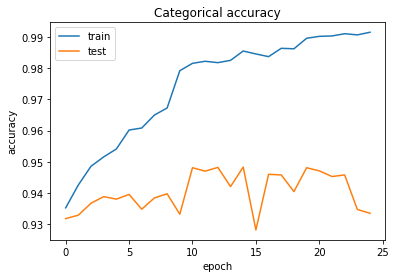

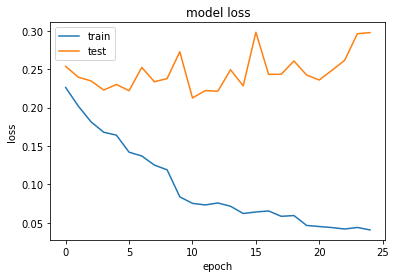

In [0]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# results.history

In [0]:
#load best model according to cross-validation - model-attRNN
model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [0]:
valEval = model.evaluate_generator(valGen, use_multiprocessing=True, workers=4,verbose=1)
trainEval = model.evaluate_generator(trainGen, use_multiprocessing=True, workers=4,verbose=1)
testEval = model.evaluate(x_test, y_test, verbose=1)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

11005/11005 [==============================] - 6s 590us/step
Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.05389102231580457, 0.9881721698113207] 
Validation: [0.24245794078996105, 0.9471774193548387] 
Test: [0.24970048266776737, 0.9385733757978784]


In [0]:
kaggle12cmd = False
if kaggle12cmd:
    #only for the Kaggle competition, 12-cmd
    x_testR, y_testR = testRGen.__getitem__(0)
    testREval = model.evaluate(x_testR, y_testR, verbose=1)
    print(testREval)
    testREval = model.evaluate_generator(testRGen, use_multiprocessing=True, workers=4,verbose=1)
    print(testREval)

## Evaluation and Attention Plots

In [0]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [0]:
audios, classes = valGen.__getitem__(3)
classes

array([ 5, 24, 33, 27, 30,  9,  5, 31,  5, 20, 16, 29, 25, 27,  6,  3, 30,
       31, 26, 30,  4, 24, 18,  1,  1, 34, 22, 28, 23,  8, 11,  7,  2,  9,
        2, 12,  8,  6,  5, 22, 10, 20, 12, 10,  5, 25,  2,  6, 35, 15, 17,
       18, 19, 23,  7, 20, 25,  9, 19,  9,  3, 14,  9, 10])

In [0]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

5

In [0]:
outs, attW, specs = attSpeechModel.predict( audios )

In [0]:
np.argmax(outs,axis=1)

array([ 5, 24, 33, 27, 30,  9,  5, 31,  5, 20, 16, 24, 25, 27,  6,  3, 30,
       31, 26, 30,  4, 24, 18,  1,  1, 34, 22, 28, 23,  8, 11,  7,  2,  9,
        2, 12,  8,  6,  5, 22,  4, 20, 12, 10,  5, 25,  2,  6, 35, 15, 17,
       18, 19, 23,  7, 20, 25,  9, 19,  9,  3, 14,  9, 10])

In [0]:
specs.shape

(64, 80, 125, 1)

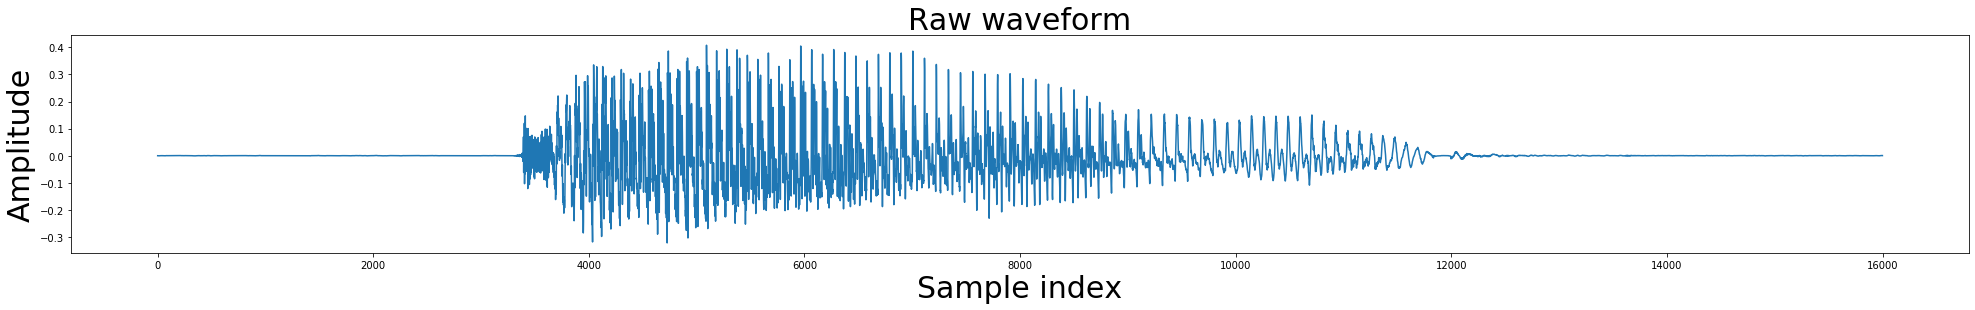

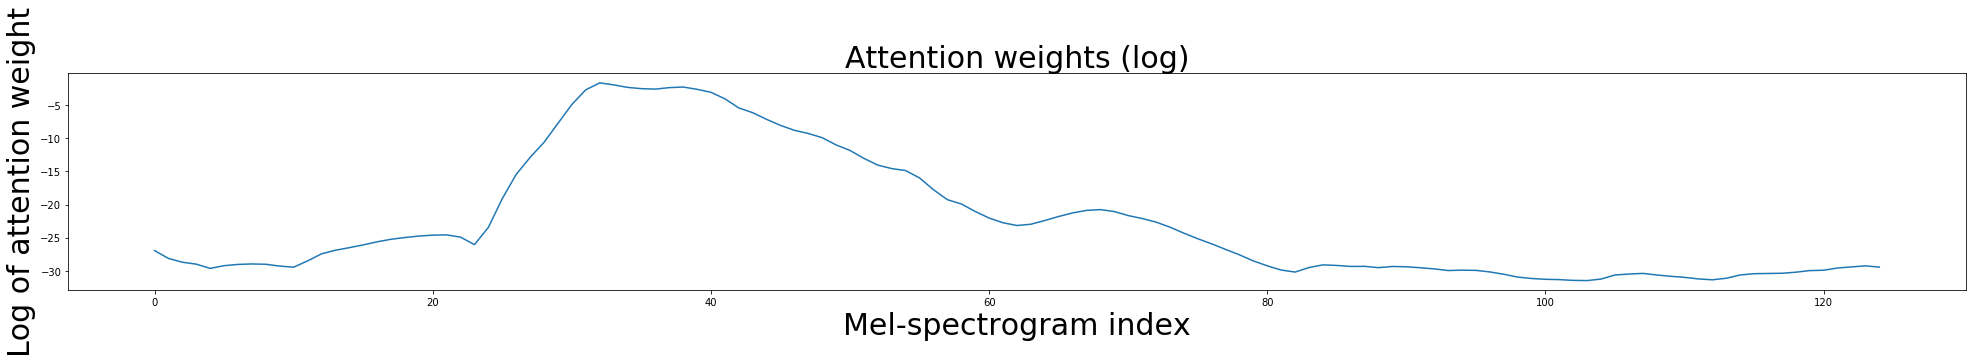

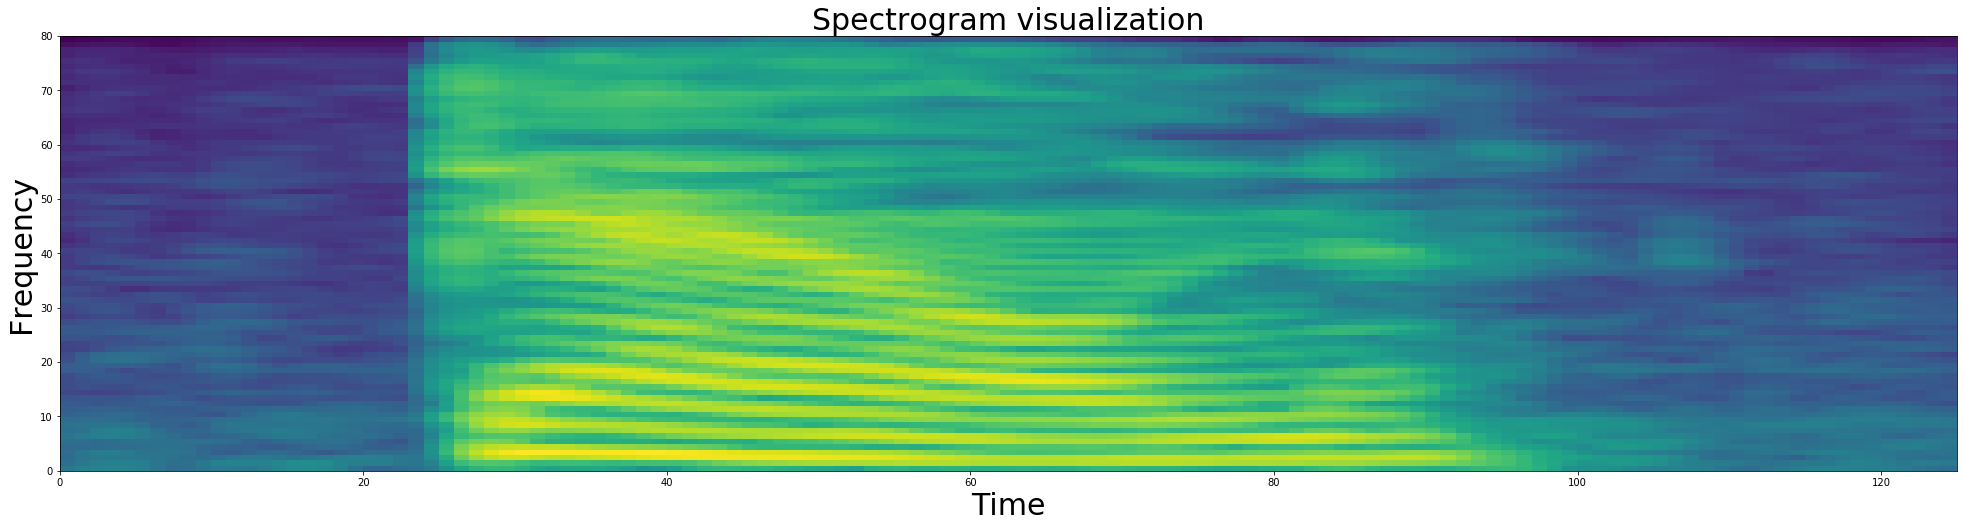

In [0]:

imgHeight = 2*2

plt.figure(figsize=(17*2,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17*2,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17*2,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [0]:
y_pred = model.predict(x_test, verbose=1)

11005/11005 [==============================] - 6s 569us/step


In [0]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [0]:
set(y_test)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35}

In [0]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [0]:
#35word, v1
#classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 
#         'bed', 'bird', 'cat', 'dog', 'happy', 'house', 
#         'marvin', 'sheila', 'tree', 'wow']

In [0]:
#20cmd
#classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Confusion matrix, without normalization


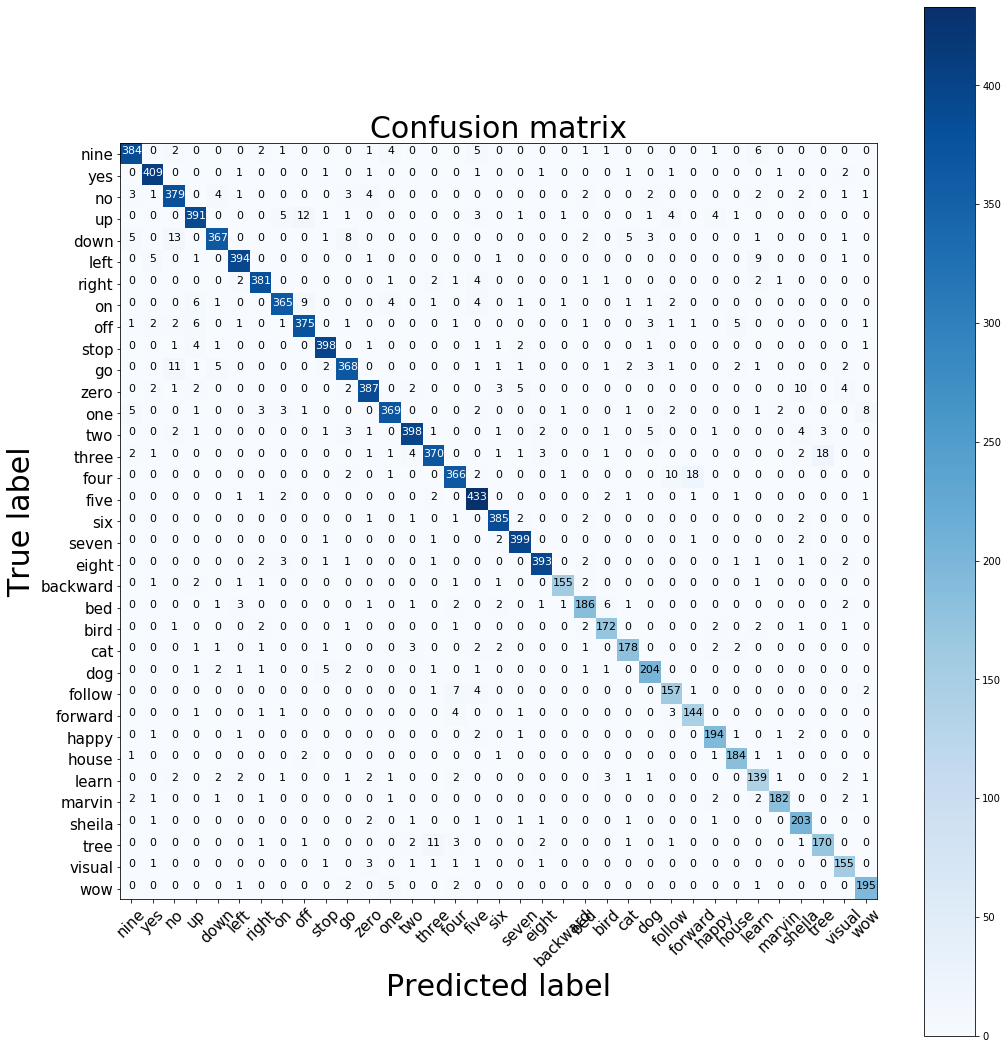

In [0]:
audioUtils.plot_confusion_matrix(cm,classes, normalize=False)

In [0]:
import keras
import pandas as pd
import kapre
[tf.__version__, keras.__version__, kapre.__version__, pd.__version__, librosa.__version__]

['1.15.0', '2.2.5', '0.1.3.1', '0.25.3', '0.6.3']

# Save model to .pb

In [0]:
# model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
# model.load_weights('model-attRNN.h5')

model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [0]:
# save model to pb ====================
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.
    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph



In [0]:
wkdir = ''
pb_filename = 'attRNN.pb'

# save keras model as tf pb files ===============
from keras import backend as K
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, wkdir, pb_filename, as_text=False)